In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import scipy
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, LogisticRegression, PoissonRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import pathlib
import sklearn.metrics
from scipy.stats import gaussian_kde
import matplotlib.cm as cm

import random
import time

In [2]:

def model_outcomes_coal(model, coal, local_obs, ref_point, imp=None, predict_proba=True, seed=0):
    
    start = time.time()
    
    ## this function outputs a list of all model predictions for a single coalition
    # the input is the coalition of interest as a binary vector eg. [1,1,0,1]
    # ref point is the entire reference distirbution (here we take x_train)
    # local_obs is the instance we aim to explain
    
    n_obs, d_obs = np.shape(local_obs)

    # we consider all 2**n coalitions and all n reference points
    # get constants
    
    n, d = np.shape(ref_point)
    assert d == d_obs
    
    # train imputation algorithm for conditional references   
    # create an "all_imputed_coalitions" 3D matrix with all "artificial inputs" we get by imputing
    coalitions = np.array([[int(i) for i in '0'*((d)-len(bin(j))+2) + bin(j)[2:]] for j in range(2**d)]) 
    all_imputed_coalitions = np.zeros((n_obs, n, d))
    
    
    
    
    
     ## below we build the concatenated inputs using conditional imputation for dropped features and averages
    for k in range(n):#reference point index
        vect=(1-coal) 
        vect = vect.astype('float')
        vect[vect == 1] = 'nan'    # vect is a binary vector of being "absent" ('nan') or "present" (1)
        # impute conditionally with Bayesian Ridge MICE 
        imputed_coalitions = coal * local_obs + vect #either local obs value or 'nan'
        #print(imputed_coalitions)
        nans = (np.isnan(imputed_coalitions).sum(axis=0) > 0)
        if (~nans).sum() == 0 or imp is None:
            idx = np.random.randint(n, size=n_obs)
            imputation = ref_point[idx]
            imputed_coalitions[:,nans] = imputation[:,nans]
        else:
            imputed_coalitions = imp.transform(imputed_coalitions)       
        all_imputed_coalitions[:, k, :] = imputed_coalitions
        
    end = time.time()
    print('Execution time (s) :', end - start)
    #we ultimately return the model predictions
    if predict_proba:
        return model.predict_proba(all_imputed_coalitions.reshape(n_obs * n, d))[:,1].reshape(n_obs, n)
    else:
        return model.predict(all_imputed_coalitions.reshape(n_obs * n, d)).reshape(n_obs, n)


In [4]:
prop_train = 0.5

data = pd.read_csv('../data/german_processed.csv')
rng = np.random.default_rng(0)
rng.permutation(data) 
N = len(data)
N_train = int(prop_train * N)

train_df, test_df = data.iloc[:N_train], data.iloc[N_train:]



y_train = train_df['GoodCustomer (label)']
x_train = train_df.drop(columns=['GoodCustomer (label)'])

y_test = test_df['GoodCustomer (label)']
x_test = test_df.drop(columns=['GoodCustomer (label)'])


In [5]:
# fit and score the model
outcome = LogisticRegression(random_state=0)
outcome.fit(x_train, y_train)
print(sklearn.metrics.accuracy_score(y_train, outcome.predict(x_train)))
print(sklearn.metrics.roc_auc_score(y_train, outcome.predict_proba(x_train)[:, 1]))
print(sklearn.metrics.accuracy_score(y_test, outcome.predict(x_test)))
print(sklearn.metrics.roc_auc_score(y_test, outcome.predict_proba(x_test)[:, 1]))

0.734
0.6696428571428572
0.68
0.6171784262485482


## Treatment = Sex (mediation analysis)

In [6]:
propensity_sex = LogisticRegression(random_state=0)
propensity_sex.fit(x_train.drop(columns=['Sex']), x_train['Sex'])
print(sklearn.metrics.accuracy_score(x_train['Sex'], propensity_sex.predict(x_train.drop(columns=['Sex']))))
print(sklearn.metrics.roc_auc_score(x_train['Sex'], propensity_sex.predict_proba(x_train.drop(columns=['Sex']))[:, 1]))
print(sklearn.metrics.accuracy_score(x_test['Sex'], propensity_sex.predict(x_test.drop(columns=['Sex']))))
print(sklearn.metrics.roc_auc_score(x_test['Sex'], propensity_sex.predict_proba(x_test.drop(columns=['Sex']))[:, 1]))

0.696
0.6118988203266787
0.684
0.656210674365238


In [7]:
imp = IterativeImputer(max_iter=100, random_state=0, sample_posterior=True)
imp.fit(x_train.values) #imputer learns from marginal distribution

IterativeImputer(max_iter=100, random_state=0, sample_posterior=True)

In [8]:
inst=20 # chose your treated instance
print(x_test.iloc[inst,:])
print('----')
print(y_test.iloc[inst])
print(outcome.predict_proba(x_test)[inst,1])
print(np.mean(outcome.predict_proba(x_train)[:,1]))

Sex                1.0
Age               44.0
Credit          5507.0
LoanDuration      24.0
Name: 520, dtype: float64
----
1.0
0.7133023045412202
0.7280000941945143


In [9]:
from scipy import stats

65.3623188405797


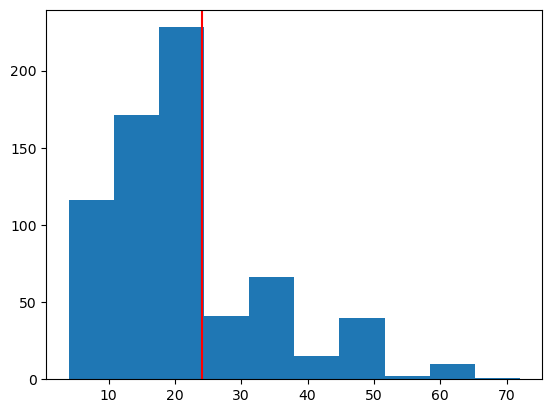

In [10]:
import matplotlib.pyplot as plt
mask = data['Sex'] == 1
print(stats.percentileofscore(data['LoanDuration'][mask], x_test.iloc[inst,:]['LoanDuration']))
plt.hist(data['LoanDuration'][mask])
plt.axvline(x=x_test.iloc[inst,:]['LoanDuration'], color='red')

81.30434782608695


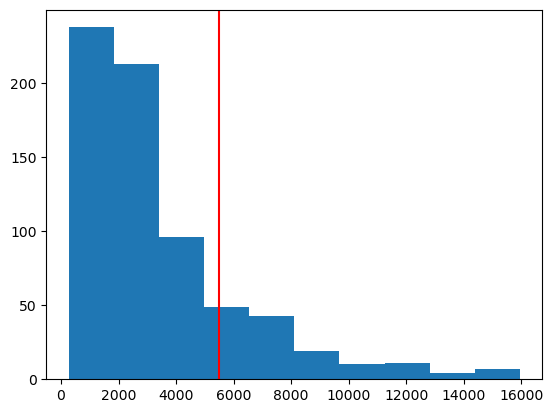

In [11]:
import matplotlib.pyplot as plt
mask = data['Sex'] == 1
print(stats.percentileofscore(data['Credit'][mask], x_test.iloc[inst,:]['Credit']))
plt.hist(data['Credit'][mask])
plt.axvline(x=x_test.iloc[inst,:]['Credit'], color='red')

In [12]:
# COALITION-SPECIFIC SHAPLEY TERMS: an example (we only want the mean prediction over all reference points ultimately)

model_outcome_all= np.mean(model_outcomes_coal(outcome, np.array([1, 1, 1, 1]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp, seed=0))
model_outcome_all_but_sex = np.mean(model_outcomes_coal(outcome, np.array([0, 1, 1, 1]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp, seed=0))
model_outcome_all_but_credit= np.mean(model_outcomes_coal(outcome, np.array([1, 1, 0, 1]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp, seed=0))
model_outcome_all_but_sex_credit = np.mean(model_outcomes_coal(outcome, np.array([0, 1, 0, 1]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp, seed=0))

print('model_outcome_all '+str(model_outcome_all))
print('model_outcome_all_but_sex '+str(model_outcome_all_but_sex))
print('model_outcome_all_but_credit '+str(model_outcome_all_but_credit))
print('model_outcome_all_but_sex_credit '+str(model_outcome_all_but_sex_credit))


Execution time (s) : 1.4196689128875732


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 51.33233976364136


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 62.70551109313965


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 116.63162660598755
model_outcome_all 0.7133023045412201
model_outcome_all_but_sex 0.6928323419030074
model_outcome_all_but_credit 0.737974366885455
model_outcome_all_but_sex_credit 0.7167359477866448


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [13]:
model_outcome_all_but_duration= np.mean(model_outcomes_coal(outcome, np.array([1, 1, 1, 0]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp, seed=0))
model_outcome_all_but_sex_duration = np.mean(model_outcomes_coal(outcome, np.array([0, 1, 1, 0]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp, seed=0))

model_outcome_all_but_credit_duration= np.mean(model_outcomes_coal(outcome, np.array([1, 1, 0, 0]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp, seed=0))
model_outcome_all_but_sex_credit_duration = np.mean(model_outcomes_coal(outcome, np.array([0, 1, 0, 0]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp, seed=0))


Execution time (s) : 63.473724126815796


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 118.8544511795044


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 111.34647798538208


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 167.37281680107117


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [14]:
imp_all_but_sex = IterativeImputer(max_iter=100, random_state=0, sample_posterior=True)
imp_all_but_sex.fit(x_train.drop(columns=['Sex']).values)

IterativeImputer(max_iter=100, random_state=0, sample_posterior=True)

In [15]:
# weights : 1 - P(T=1 knowing CS) example:
weight_all_but_sex= 1-np.mean(model_outcomes_coal(propensity_sex, np.array([1, 1, 1]), local_obs=x_test.drop(columns=['Sex']).iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.drop(columns=['Sex']).values, imp=imp_all_but_sex, seed=0))
weight_all_but_sex_credit = 1-np.mean(model_outcomes_coal(propensity_sex, np.array([1, 0, 1]), local_obs=x_test.drop(columns=['Sex']).iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.drop(columns=['Sex']).values, imp=imp_all_but_sex, seed=0))
weight_all_but_sex_duration = 1-np.mean(model_outcomes_coal(propensity_sex, np.array([1, 1, 0]), local_obs=x_test.drop(columns=['Sex']).iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.drop(columns=['Sex']).values, imp=imp_all_but_sex, seed=0))
weight_all_but_sex_credit_duration = 1-np.mean(model_outcomes_coal(propensity_sex, np.array([1, 0, 0]), local_obs=x_test.drop(columns=['Sex']).iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.drop(columns=['Sex']).values, imp=imp_all_but_sex, seed=0))

print('weight_all_but_sex '+str(weight_all_but_sex))
print('weight_all_but_sex_credit '+str(weight_all_but_sex_credit))
print('weight_all_but_sex_duration '+str(weight_all_but_sex_duration))
print('weight_all_but_sex_credit_duration '+str(weight_all_but_sex_credit_duration))

Execution time (s) : 0.9814727306365967


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 56.71106767654419


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 57.62569713592529


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 111.38366293907166
weight_all_but_sex 0.24888435493286154
weight_all_but_sex_credit 0.2565482001303895
weight_all_but_sex_duration 0.251194644342395
weight_all_but_sex_credit_duration 0.25562779590663265


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [16]:
phi_med_by_credit=((model_outcome_all-model_outcome_all_but_credit)/weight_all_but_sex)-((model_outcome_all_but_credit-model_outcome_all_but_sex_credit)/weight_all_but_sex_credit)
phi_med_by_duration=((model_outcome_all-model_outcome_all_but_duration)/weight_all_but_sex)-((model_outcome_all_but_duration-model_outcome_all_but_sex_duration)/weight_all_but_sex_duration)
phi_med_by_credit_duration=((model_outcome_all-model_outcome_all_but_credit_duration)/weight_all_but_sex)-((model_outcome_all_but_credit_duration-model_outcome_all_but_sex_credit_duration)/weight_all_but_sex_credit_duration)
print('phi_med_by_credit ' +str(phi_med_by_credit))
print('phi_med_by_duration ' +str(phi_med_by_duration))
print('phi_med_by_credit_duration ' +str(phi_med_by_credit_duration))


phi_med_by_credit -0.18191592536924678
phi_med_by_duration 0.018810230029635444
phi_med_by_credit_duration -0.23709758505440673


In [17]:
model_outcome_sex_only = np.mean(model_outcomes_coal(outcome, np.array([1, 0, 0, 0]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp, seed=0))
model_outcome_empty = np.mean(model_outcomes_coal(outcome, np.array([0, 0, 0, 0]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp, seed=0))
weight_empty = 1-np.mean(model_outcomes_coal(propensity_sex, np.array([0, 0, 0]), local_obs=x_test.drop(columns=['Sex']).iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.drop(columns=['Sex']).values, imp=imp_all_but_sex, seed=0))
phi_total=((model_outcome_sex_only-model_outcome_empty)/weight_empty)
print('phi_total ' +str(phi_total))


Execution time (s) : 173.27045798301697
Execution time (s) : 0.020790576934814453
Execution time (s) : 0.020689725875854492
phi_total 0.06385957224392631


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [18]:
print('phi_total ' +str(phi_total))


phi_total 0.06385957224392631


## Causal Shapley

In [19]:
class IterativeImputerSubsets(object):
    
    def __init__(self, subsets=[], **kwargs):
        
        self.imps = []
        self.subsets = subsets
        for subset in self.subsets: 
            self.imps.append(IterativeImputer(**kwargs))

        
    def fit(self, x_train):
        for imp,subset in zip(self.imps, self.subsets):
            x_train_subset = x_train[:, subset]
            imp.fit(x_train_subset)
        
    def transform(self, x):
        x_new = x
        for imp,subset in zip(self.imps,self.subsets):
            x_new[:, subset] = imp.transform(x[:, subset])
        return x_new
    
        

In [20]:
imp_without_sex = IterativeImputerSubsets([[False,True,True,True]], max_iter=100, random_state=0, sample_posterior=True)
imp_without_sex.fit(x_train.values) #imputer learns from marginal distribution

In [21]:
# decorrelate a subset of features from others (but not between features in said subset)
def decorrelate_x_train(x_train, mask_to_decorrelate):
    x_train_decorrelated = x_train
    idx = np.random.randint(len(x_train), size=len(x_train))
    x_train_sampled = x_train[idx]
    x_train_decorrelated[:,mask_to_decorrelate] = x_train_sampled[:,mask_to_decorrelate]
    return x_train_decorrelated

In [22]:
x_train_do_credit = decorrelate_x_train(x_train.values, [False,False,True,True])
imp_do_credit = IterativeImputer(max_iter=100, random_state=0, sample_posterior=True)
imp_do_credit.fit(x_train_do_credit) 
imp_do_credit_without_sex =  IterativeImputerSubsets([[False,True,True,True]], max_iter=100, random_state=0, sample_posterior=True)
imp_do_credit_without_sex.fit(x_train_do_credit) 

In [23]:
x_train_do_duration = decorrelate_x_train(x_train.values, [False,False,False,True])
imp_do_duration = IterativeImputer(max_iter=100, random_state=0, sample_posterior=True)
imp_do_duration.fit(x_train_do_duration) 
imp_do_duration_without_sex =  IterativeImputerSubsets([[False,True,True,True]], max_iter=100, random_state=0, sample_posterior=True)
imp_do_duration_without_sex.fit(x_train_do_duration) 

In [24]:
# Full coalition - the distribution is mutually independent
model_outcome_all_cs = np.mean(model_outcomes_coal(outcome, np.array([1, 1, 1, 1]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=None, seed=0))
model_outcome_all_but_sex_cs = np.mean(model_outcomes_coal(outcome, np.array([0, 1, 1, 1]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=None, seed=0))
model_outcome_all_impwithoutsex_cs = np.mean(model_outcomes_coal(outcome, np.array([1, 1, 1, 1]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=None, seed=0))

phi_direct_cs_full_coalition = model_outcome_all_impwithoutsex_cs - model_outcome_all_but_sex_cs
phi_indirect_cs_full_coalition = model_outcome_all_cs - model_outcome_all_impwithoutsex_cs
phi_direct_cs_full_coalition, phi_indirect_cs_full_coalition

Execution time (s) : 0.038576602935791016
Execution time (s) : 0.027872562408447266
Execution time (s) : 0.03819394111633301


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


(0.02503473881392071, 0.0)

In [25]:
# Credit and duration coalition - the distribution is mutually independent
model_outcome_all_but_age_cs = np.mean(model_outcomes_coal(outcome, np.array([1, 0, 1, 1]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=None, seed=0))
model_outcome_all_but_sex_age_cs = np.mean(model_outcomes_coal(outcome, np.array([0, 0, 1, 1]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=None, seed=0))
model_outcome_all_but_age_impwithoutsex_cs = np.mean(model_outcomes_coal(outcome, np.array([1, 0, 1, 1]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=None, seed=0))

phi_direct_cs_credit_duration_coalition = model_outcome_all_but_age_impwithoutsex_cs - model_outcome_all_but_sex_age_cs
phi_indirect_cs_credit_duration_coalition = model_outcome_all_but_age_cs - model_outcome_all_but_age_impwithoutsex_cs
phi_direct_cs_credit_duration_coalition, phi_indirect_cs_credit_duration_coalition

Execution time (s) : 0.0336909294128418
Execution time (s) : 0.028975725173950195
Execution time (s) : 0.026050567626953125


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


(0.02540511385424915, 0.00075283507963253)

In [26]:
# Age and duration coalition - credit is still dependent on sex and age but duration becomes independent
model_outcome_all_but_credit_cs = np.mean(model_outcomes_coal(outcome, np.array([1, 1, 0, 1]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp_do_duration, seed=0))
model_outcome_all_but_sex_credit_cs = np.mean(model_outcomes_coal(outcome, np.array([0, 1, 0, 1]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp_do_duration, seed=0))
model_outcome_all_but_credit_impwithoutsex_cs = np.mean(model_outcomes_coal(outcome, np.array([1, 1, 0, 1]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp_do_duration_without_sex, seed=0))

phi_direct_cs_age_duration_coalition = model_outcome_all_but_credit_impwithoutsex_cs - model_outcome_all_but_sex_credit_cs
phi_indirect_cs_age_duration_coalition = model_outcome_all_but_credit_cs - model_outcome_all_but_credit_impwithoutsex_cs
phi_direct_cs_age_duration_coalition, phi_indirect_cs_age_duration_coalition

Execution time (s) : 58.661588191986084


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 120.74186611175537


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 58.08226418495178


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


(0.019277581061445725, 2.586078018396165e-10)

In [27]:
# Age and credit coalition - credit is independent but duration depends on credit
model_outcome_all_but_duration_cs = np.mean(model_outcomes_coal(outcome, np.array([1, 1, 1, 0]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp_do_credit, seed=0))
model_outcome_all_but_sex_duration_cs = np.mean(model_outcomes_coal(outcome, np.array([0, 1, 1, 0]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp_do_credit, seed=0))
model_outcome_all_but_duration_impwithoutsex_cs = np.mean(model_outcomes_coal(outcome, np.array([1, 1, 1, 0]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp_do_credit_without_sex, seed=0))

phi_direct_cs_age_credit_coalition = model_outcome_all_but_duration_impwithoutsex_cs - model_outcome_all_but_sex_duration_cs
phi_indirect_cs_age_credit_coalition = model_outcome_all_but_duration_cs - model_outcome_all_but_duration_impwithoutsex_cs
phi_direct_cs_age_credit_coalition, phi_indirect_cs_age_credit_coalition

Execution time (s) : 59.183905839920044


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 119.81734275817871


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 57.7238986492157


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


(0.020649097115349124, -6.162021037869891e-08)

In [28]:
# Age coalition - the do-distribution is like the conditional distribution
model_outcome_all_but_credit_duration_cs = np.mean(model_outcomes_coal(outcome, np.array([1, 1, 0, 0]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp, seed=0))
model_outcome_all_but_sex_credit_duration_cs = np.mean(model_outcomes_coal(outcome, np.array([0, 1, 0, 0]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp, seed=0))
model_outcome_all_but_credit_duration_impwithoutsex_cs = np.mean(model_outcomes_coal(outcome, np.array([1, 1, 0, 0]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp_without_sex, seed=0))

phi_direct_cs_age_coalition = model_outcome_all_but_credit_duration_impwithoutsex_cs - model_outcome_all_but_sex_credit_duration_cs
phi_indirect_cs_age_coalition = model_outcome_all_but_credit_duration_cs - model_outcome_all_but_credit_duration_impwithoutsex_cs
phi_direct_cs_age_coalition, phi_indirect_cs_age_coalition

Execution time (s) : 111.2486367225647


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 177.3137903213501


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 120.71589159965515


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


(0.016986249998860448, 0.004590392112703623)

In [29]:
# Credit coalition - credit is independent but duration depends on credit
model_outcome_all_but_age_duration_cs = np.mean(model_outcomes_coal(outcome, np.array([1, 0, 1, 0]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp_do_credit, seed=0))
model_outcome_all_but_sex_age_duration_cs = np.mean(model_outcomes_coal(outcome, np.array([0, 0, 1, 0]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp_do_credit, seed=0))
model_outcome_all_but_age_duration_impwithoutsex_cs = np.mean(model_outcomes_coal(outcome, np.array([1, 0, 1, 0]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp_do_credit_without_sex, seed=0))

phi_direct_cs_credit_coalition = model_outcome_all_but_age_duration_impwithoutsex_cs - model_outcome_all_but_sex_age_duration_cs
phi_indirect_cs_credit_coalition = model_outcome_all_but_age_duration_cs - model_outcome_all_but_age_duration_impwithoutsex_cs
phi_direct_cs_credit_coalition, phi_indirect_cs_credit_coalition

Execution time (s) : 128.25567770004272


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 186.42379117012024


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 116.98232555389404


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


(0.027354042468397233, -0.002490234972978733)

In [30]:
# Duration coalition - credit is still dependent on sex and age but duration becomes independent
model_outcome_all_but_age_credit_cs = np.mean(model_outcomes_coal(outcome, np.array([1, 0, 0, 1]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp_do_duration, seed=0))
model_outcome_all_but_sex_age_credit_cs = np.mean(model_outcomes_coal(outcome, np.array([0, 0, 0, 1]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp_do_duration, seed=0))
model_outcome_all_but_age_credit_impwithoutsex_cs = np.mean(model_outcomes_coal(outcome, np.array([1, 0, 0, 1]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp_do_duration_without_sex, seed=0))

phi_direct_cs_duration_coalition = model_outcome_all_but_age_credit_impwithoutsex_cs - model_outcome_all_but_sex_age_credit_cs
phi_indirect_cs_duration_coalition = model_outcome_all_but_age_credit_cs - model_outcome_all_but_age_credit_impwithoutsex_cs
phi_direct_cs_duration_coalition, phi_indirect_cs_duration_coalition

Execution time (s) : 119.47027063369751


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 166.37941241264343


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Execution time (s) : 115.44391918182373


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


(0.02518009489642259, -0.0017089441178576026)

In [31]:
# Null coalition - - the do-distribution is like the conditional distribution
model_outcome_all_but_age_credit_duration_cs = np.mean(model_outcomes_coal(outcome, np.array([1, 0, 0, 0]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp, seed=0))
model_outcome_all_but_sex_age_credit_duration_cs = np.mean(model_outcomes_coal(outcome, np.array([0, 0, 0, 0]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp, seed=0))
model_outcome_all_but_age_credit_duration_impwithoutsex_cs = np.mean(model_outcomes_coal(outcome, np.array([1, 0, 0, 0]), local_obs=x_test.iloc[inst,:].values.reshape((1,-1)), ref_point=x_train.values, imp=imp_without_sex, seed=0))

phi_direct_cs_empty_coalition = model_outcome_all_but_age_credit_duration_impwithoutsex_cs - model_outcome_all_but_sex_age_credit_duration_cs
phi_indirect_cs_empty_coalition = model_outcome_all_but_age_credit_duration_cs - model_outcome_all_but_age_credit_impwithoutsex_cs
phi_direct_cs_empty_coalition, phi_indirect_cs_empty_coalition

Execution time (s) : 170.43746042251587
Execution time (s) : 0.023874521255493164
Execution time (s) : 0.16155695915222168


/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/clivio/miniconda3/envs/pwshap/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


(0.03502315809999279, 0.017635615972740215)

In [32]:
phi_direct_cs = 1/4*phi_direct_cs_full_coalition + 1/12*phi_direct_cs_credit_duration_coalition + 1/12*phi_direct_cs_age_duration_coalition+ 1/12*phi_direct_cs_age_credit_coalition + 1/12*phi_direct_cs_age_coalition+ 1/12*phi_direct_cs_credit_coalition + 1/12*phi_direct_cs_duration_coalition + 1/4*phi_direct_cs_empty_coalition
phi_indirect_cs = 1/4*phi_indirect_cs_full_coalition + 1/12*phi_indirect_cs_credit_duration_coalition + 1/12*phi_indirect_cs_age_duration_coalition+ 1/12*phi_indirect_cs_age_credit_coalition + 1/12*phi_indirect_cs_age_coalition+ 1/12*phi_indirect_cs_credit_coalition + 1/12*phi_indirect_cs_duration_coalition + 1/4*phi_indirect_cs_empty_coalition


print('phi_direct_cs ', phi_direct_cs)
print('phi_indirect_cs ',  phi_indirect_cs)




phi_direct_cs  0.026252155844705395
phi_indirect_cs  0.0045042362215098235
